# Commalla OpenSMILE ML

[Feature Importance Tutorial](https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285#:~:text=Feature%20Importance%20refers%20to%20techniques,to%20predict%20a%20certain%20variable) <br/>
[Regression Metrics](https://scikit-learn.org/stable/modules/classes.html#regression-metrics)

In [1]:
import os 
import pandas as pd
import numpy as np

import audb
import audiofile
import opensmile

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

In [26]:
commalla_compare_2016 = pd.read_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/commalla_compare_2016.csv")
commalla_compare_2016 = commalla_compare_2016.dropna()

arousal_regression = False 
if arousal_regression:
    commalla_compare_2016 = commalla_compare_2016.drop("mean_valence", axis=1)
else: # valence regression 
    commalla_compare_2016 = commalla_compare_2016.drop("mean_arousal", axis=1)

# Arousal Aggregate

## ComParE-2016 Subsets

In [18]:
all_cols = commalla_compare_2016.columns[6:]
fband_cols = []
fband250_650_cols = []
fband1000_4000_cols = []

for param_name in commalla_compare_2016.columns:
    if "pcm_fftMag_fband" in param_name:
        fband_cols.append(param_name)
    if "pcm_fftMag_fband250-650" in param_name:
        fband250_650_cols.append(param_name)
    if "pcm_fftMag_fband1000-4000" in param_name:
        fband1000_4000_cols.append(param_name) 

param_set_list = [all_cols, fband_cols, fband250_650_cols, fband1000_4000_cols]
param_set_names = ["All Parameters", "pcm_fftMag_fband", "pcm_fftMag_fband250-650", "pcm_fftMag_fband1000-4000"]

param_importances = pd.DataFrame({
    "param_set":[], 
    "param_name":[],
    "importance":[],
    })

param_set_stats = pd.DataFrame({
    "param_set":[], 
    "statistic":[],
    "value":[],
    })

In [25]:
def compare_2016_subset_rf(subset_index, df_1, df_2):
    i = subset_index
    param_set_stats = df_1
    param_importances = df_2
    
    param_set = param_set_list[i]

    X = commalla_compare_2016[commalla_compare_2016.columns.intersection(param_set)]
    y = commalla_compare_2016.mean_arousal

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    rf = RandomForestRegressor(n_estimators=10) # formerly 100
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)

    new_row_stats = pd.DataFrame({
        "param_set":[param_set_names[i]]*3, 
        "statistic":["mse", "explained_variance", "r2"],
        "value":[mean_squared_error(y_test, y_pred_test), 
                explained_variance_score(y_test, y_pred_test), 
                r2_score(y_test, y_pred_test)]
    })
    param_set_stats = pd.concat([param_set_stats, new_row_stats])
    
    sort = rf.feature_importances_.argsort()[::-1][:10] # have to reverse order???
    for j in sort:
        new_row_importances = pd.DataFrame({
            "param_set":[param_set_names[i]], 
            "param_name":[X.columns[j]],
            "importance":[rf.feature_importances_[j]],
            })
        param_importances = pd.concat([param_importances, new_row_importances])

    return (param_set_stats, param_importances)

In [62]:
for i in range(len(param_set_list)):
    for num_runs in range(100):
        param_set_stats, param_importances = compare_2016_subset_rf(i, param_set_stats, param_importances)
        compare_2016_subset_rf(i, param_set_stats, param_importances)

### Charts

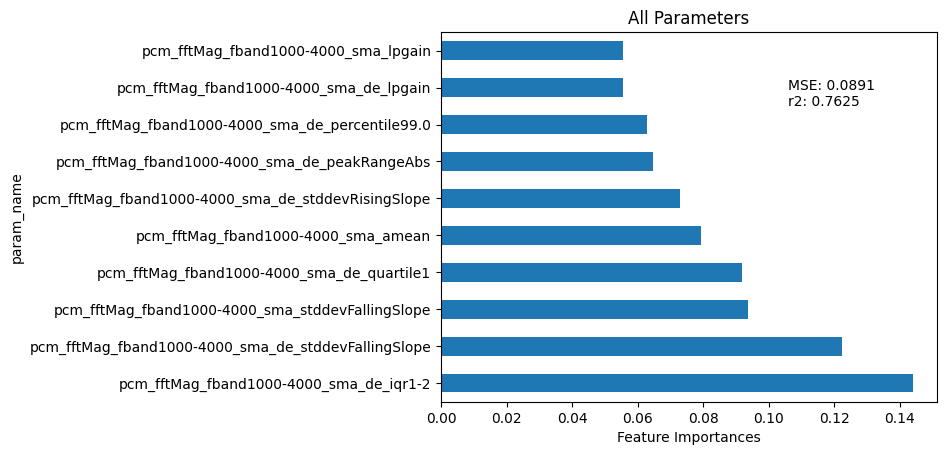

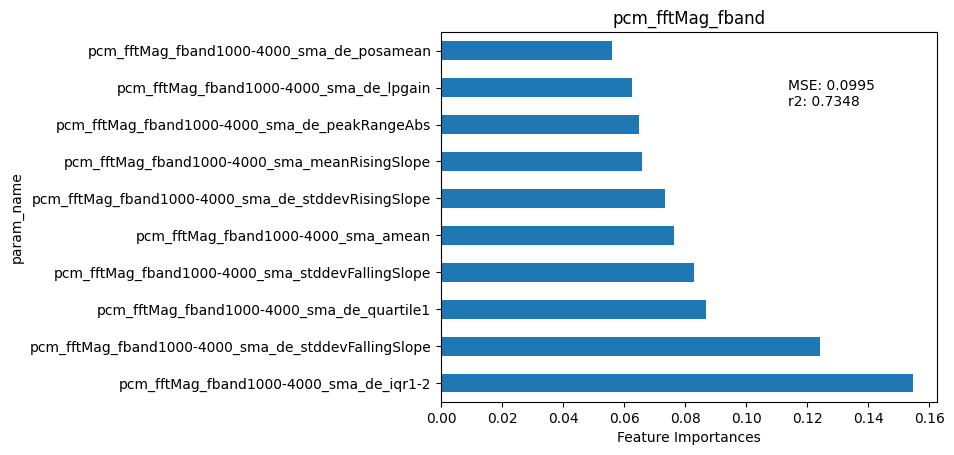

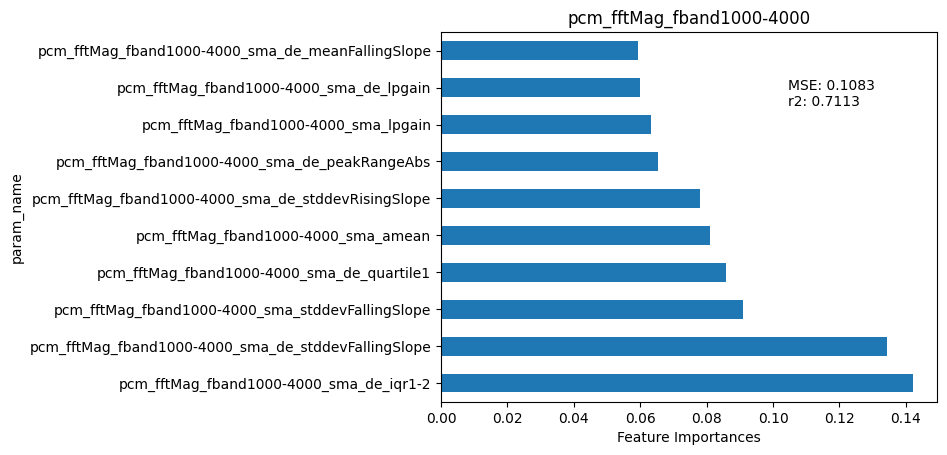

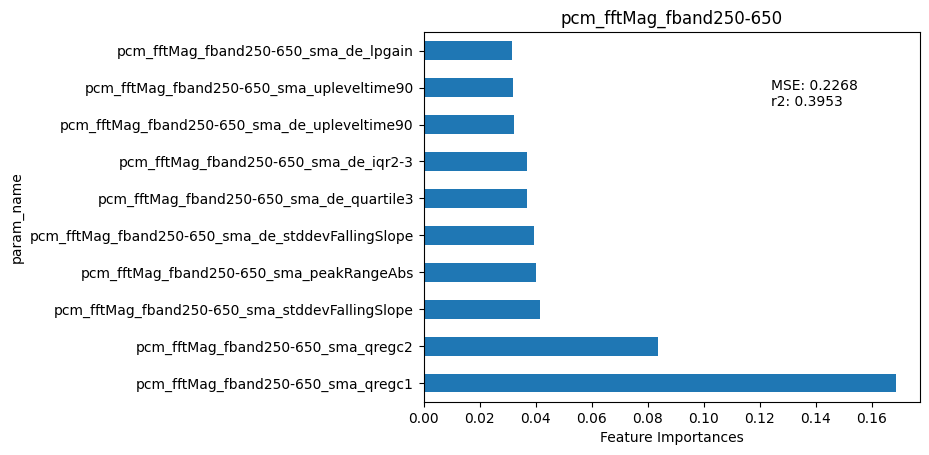

In [71]:
stats_summary = param_set_stats.groupby(by=["param_set", "statistic"], as_index=False).mean()
importances_summary = param_importances.groupby(by=["param_set", "param_name"], as_index=False).mean()
    
show_plot = True
for set_name in stats_summary.param_set.unique():
    stats_subset = stats_summary.loc[stats_summary["param_set"]==set_name]
    stats_subset = stats_subset.reset_index()

    importances_subset = importances_summary.loc[importances_summary["param_set"]==set_name]
    importances_subset = importances_subset.sort_values(by=["importance"], ascending=False)[:10]

    expl_var = round( stats_subset.at[0, "value"], 4)
    mse = round( stats_subset.at[1, "value"], 4)
    r2score = round( stats_subset.at[2, "value"], 4)
    plot_text = " ".join(["MSE:", str(mse), "\nr2:", str(r2score)]) # "\nVar Expl.:", str(expl_var),

    if show_plot:
        ax = importances_subset.plot.barh(x='param_name', y='importance', legend=False)        
        ax.set_title(set_name)
        ax.set_xlabel("Feature Importances")
        ax.annotate(plot_text, xy=(0.7, 0.8), xycoords='axes fraction')
        plt.show()

## Original Features 

In [84]:
commalla_audio_stats = pd.read_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/files for acoustic_analysis/commalla_audio_stats.csv")

av_stats_melt = pd.read_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/av_stats_melt.csv")
arousal_unmelt = av_stats_melt.groupby(by="filename")["mean_arousal"].mean()

commalla_audio_stats = pd.merge(commalla_audio_stats, arousal_unmelt, how="left", on="filename")
mean_arousal = commalla_audio_stats.pop("mean_arousal")
commalla_audio_stats.insert(5, 'mean_arousal', mean_arousal)
to_drop = ["Unnamed: 0", "full_pathname", "filename", "recanvo_id", "function"]
commalla_audio_stats = commalla_audio_stats.drop(columns=to_drop).dropna()

X = commalla_audio_stats.drop(columns=["mean_arousal"])
y = commalla_audio_stats.mean_arousal

param_importances_2 = pd.DataFrame({
    "param_set":[], 
    "param_name":[],
    "importance":[],
    })

param_set_stats_2 = pd.DataFrame({
    "param_set":[], 
    "statistic":[],
    "value":[],
    })

In [85]:
def original_features_rf(df_1, df_2):
    param_set_stats = df_1
    param_importances = df_2

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    rf = RandomForestRegressor(n_estimators=10) # formerly 100
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)

    new_row_stats = pd.DataFrame({
            "param_set":["original features"]*3, 
            "statistic":["mse", "explained_variance", "r2"],
            "value":[mean_squared_error(y_test, y_pred_test), 
                    explained_variance_score(y_test, y_pred_test), 
                    r2_score(y_test, y_pred_test)]
        })
    param_set_stats = pd.concat([param_set_stats, new_row_stats]) 

    sort = rf.feature_importances_.argsort()[::-1][:10] # have to reverse order???
    for j in sort:
        new_row_importances = pd.DataFrame({
            "param_set":["original_features"], 
            "param_name":[X.columns[j]],
            "importance":[rf.feature_importances_[j]],
            })
        param_importances = pd.concat([param_importances, new_row_importances])
    
    return (param_set_stats, param_importances)

In [86]:
for num_runs in range(100):
    param_set_stats_2, param_importances_2 = original_features_rf(param_set_stats_2, param_importances_2)
    original_features_rf(param_set_stats_2, param_importances_2)

### Chart

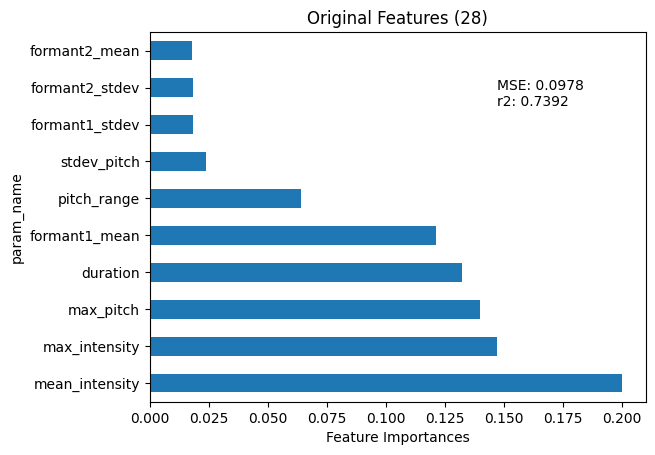

In [88]:
stats_summary = param_set_stats_2.groupby(by=["param_set", "statistic"], as_index=False).mean()
importances_summary = param_importances_2.groupby(by=["param_set", "param_name"], as_index=False).mean()

importances_subset = importances_summary.sort_values(by=["importance"], ascending=False)[:10]

expl_var = round(stats_summary.at[0, "value"], 4)
mse = round( stats_summary.at[1, "value"], 4)
r2score = round( stats_summary.at[2, "value"], 4)
plot_text = " ".join(["MSE:", str(mse), "\nr2:", str(r2score)]) # "\nVar Expl.:", str(expl_var),

ax = importances_subset.plot.barh(x='param_name', y='importance', legend=False)        
ax.set_title("Original Features (28)")
ax.set_xlabel("Feature Importances")
ax.annotate(plot_text, xy=(0.7, 0.8), xycoords='axes fraction')
plt.show()

# Valence Aggregate

## ComParE-2016 Subsets

In [27]:
all_cols = commalla_compare_2016.columns[6:]
fband_cols = []
fband250_650_cols = []
fband1000_4000_cols = []

for param_name in commalla_compare_2016.columns:
    if "pcm_fftMag_fband" in param_name:
        fband_cols.append(param_name)
    if "pcm_fftMag_fband250-650" in param_name:
        fband250_650_cols.append(param_name)
    if "pcm_fftMag_fband1000-4000" in param_name:
        fband1000_4000_cols.append(param_name) 

param_set_list = [all_cols, fband_cols, fband250_650_cols, fband1000_4000_cols]
param_set_names = ["All Parameters", "pcm_fftMag_fband", "pcm_fftMag_fband250-650", "pcm_fftMag_fband1000-4000"]

param_importances = pd.DataFrame({
    "param_set":[], 
    "param_name":[],
    "importance":[],
    })

param_set_stats = pd.DataFrame({
    "param_set":[], 
    "statistic":[],
    "value":[],
    })

In [28]:
def compare_2016_subset_rf(subset_index, df_1, df_2):
    i = subset_index
    param_set_stats = df_1
    param_importances = df_2
    
    param_set = param_set_list[i]

    X = commalla_compare_2016[commalla_compare_2016.columns.intersection(param_set)]
    y = commalla_compare_2016.mean_valence

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    rf = RandomForestRegressor(n_estimators=10) # formerly 100
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)

    new_row_stats = pd.DataFrame({
        "param_set":[param_set_names[i]]*3, 
        "statistic":["mse", "explained_variance", "r2"],
        "value":[mean_squared_error(y_test, y_pred_test), 
                explained_variance_score(y_test, y_pred_test), 
                r2_score(y_test, y_pred_test)]
    })
    param_set_stats = pd.concat([param_set_stats, new_row_stats])
    
    sort = rf.feature_importances_.argsort()[::-1][:10] # have to reverse order???
    for j in sort:
        new_row_importances = pd.DataFrame({
            "param_set":[param_set_names[i]], 
            "param_name":[X.columns[j]],
            "importance":[rf.feature_importances_[j]],
            })
        param_importances = pd.concat([param_importances, new_row_importances])

    return (param_set_stats, param_importances)

In [29]:
for i in range(1): # len(param_set_list)
    for num_runs in range(3):
        param_set_stats, param_importances = compare_2016_subset_rf(i, param_set_stats, param_importances)
        compare_2016_subset_rf(i, param_set_stats, param_importances)

### Charts

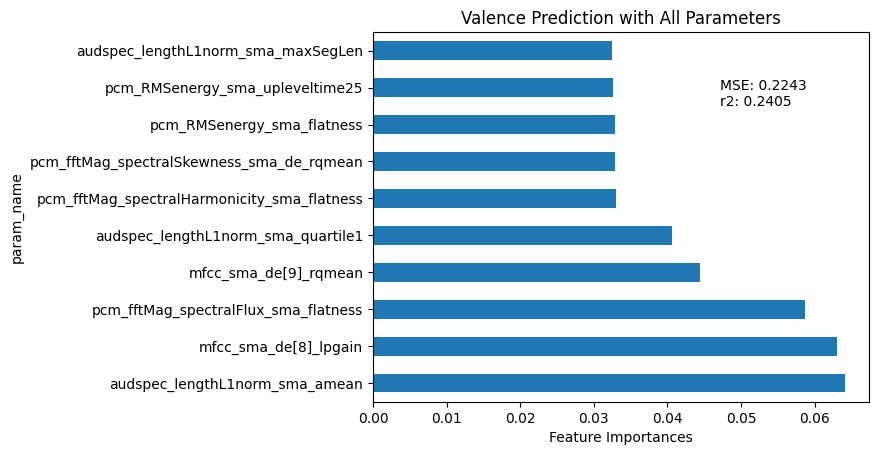

In [31]:
stats_summary = param_set_stats.groupby(by=["param_set", "statistic"], as_index=False).mean()
importances_summary = param_importances.groupby(by=["param_set", "param_name"], as_index=False).mean()
    
show_plot = True
for set_name in stats_summary.param_set.unique():
    stats_subset = stats_summary.loc[stats_summary["param_set"]==set_name]
    stats_subset = stats_subset.reset_index()

    importances_subset = importances_summary.loc[importances_summary["param_set"]==set_name]
    importances_subset = importances_subset.sort_values(by=["importance"], ascending=False)[:10]

    expl_var = round( stats_subset.at[0, "value"], 4)
    mse = round( stats_subset.at[1, "value"], 4)
    r2score = round( stats_subset.at[2, "value"], 4)
    plot_text = " ".join(["MSE:", str(mse), "\nr2:", str(r2score)]) # "\nVar Expl.:", str(expl_var),

    if show_plot:
        ax = importances_subset.plot.barh(x='param_name', y='importance', legend=False)        
        ax.set_title("Valence Prediction with "+set_name)
        ax.set_xlabel("Feature Importances")
        ax.annotate(plot_text, xy=(0.7, 0.8), xycoords='axes fraction')
        plt.show()

## Original Features 

In [22]:
commalla_audio_stats = pd.read_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/files for acoustic_analysis/commalla_audio_stats.csv")

av_stats_melt = pd.read_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/av_stats_melt.csv")
valence_unmelt = av_stats_melt.groupby(by="filename")["mean_valence"].mean()

commalla_audio_stats = pd.merge(commalla_audio_stats, valence_unmelt, how="left", on="filename")
mean_valence = commalla_audio_stats.pop("mean_valence")
commalla_audio_stats.insert(5, 'mean_valence', mean_valence)
to_drop = ["Unnamed: 0", "full_pathname", "filename", "recanvo_id", "function"]
commalla_audio_stats = commalla_audio_stats.drop(columns=to_drop).dropna()

X = commalla_audio_stats.drop(columns=["mean_valence"])
y = commalla_audio_stats.mean_valence

param_importances_2 = pd.DataFrame({
    "param_set":[], 
    "param_name":[],
    "importance":[],
    })

param_set_stats_2 = pd.DataFrame({
    "param_set":[], 
    "statistic":[],
    "value":[],
    })

In [23]:
def original_features_rf(df_1, df_2):
    param_set_stats = df_1
    param_importances = df_2

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    rf = RandomForestRegressor(n_estimators=10) # formerly 100
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)

    new_row_stats = pd.DataFrame({
            "param_set":["original features"]*3, 
            "statistic":["mse", "explained_variance", "r2"],
            "value":[mean_squared_error(y_test, y_pred_test), 
                    explained_variance_score(y_test, y_pred_test), 
                    r2_score(y_test, y_pred_test)]
        })
    param_set_stats = pd.concat([param_set_stats, new_row_stats]) 

    sort = rf.feature_importances_.argsort()[::-1][:10] # have to reverse order???
    for j in sort:
        new_row_importances = pd.DataFrame({
            "param_set":["original_features"], 
            "param_name":[X.columns[j]],
            "importance":[rf.feature_importances_[j]],
            })
        param_importances = pd.concat([param_importances, new_row_importances])
    
    return (param_set_stats, param_importances)

In [24]:
for num_runs in range(100):
    param_set_stats_2, param_importances_2 = original_features_rf(param_set_stats_2, param_importances_2)
    original_features_rf(param_set_stats_2, param_importances_2)

### Chart

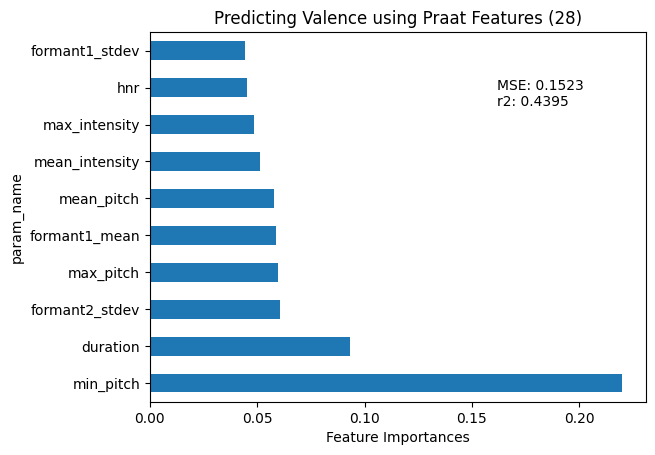

In [25]:
stats_summary = param_set_stats_2.groupby(by=["param_set", "statistic"], as_index=False).mean()
importances_summary = param_importances_2.groupby(by=["param_set", "param_name"], as_index=False).mean()

importances_subset = importances_summary.sort_values(by=["importance"], ascending=False)[:10]

expl_var = round(stats_summary.at[0, "value"], 4)
mse = round( stats_summary.at[1, "value"], 4)
r2score = round( stats_summary.at[2, "value"], 4)
plot_text = " ".join(["MSE:", str(mse), "\nr2:", str(r2score)]) # "\nVar Expl.:", str(expl_var),

ax = importances_subset.plot.barh(x='param_name', y='importance', legend=False)        
ax.set_title("Predicting Valence using Praat Features (28)")
ax.set_xlabel("Feature Importances")
ax.annotate(plot_text, xy=(0.7, 0.8), xycoords='axes fraction')
plt.show()

# OLDER CODE

## Subsets of ComParE_2016 

Includes all parameters too. You don't need to run the full ComParE_2016 Regression

### 
Defining Subsets

In [222]:
all_cols = commalla_compare_2016.columns[6:]
fband_cols = []
fband250_650_cols = []
fband1000_4000_cols = []
mfcc_sma1_cols = []
mfcc_sma2_cols = []

for param_name in commalla_compare_2016.columns:
    if "pcm_fftMag_fband" in param_name:
        fband_cols.append(param_name)
    if "pcm_fftMag_fband250-650" in param_name:
        fband250_650_cols.append(param_name)
    if "pcm_fftMag_fband1000-4000" in param_name:
        fband1000_4000_cols.append(param_name) 
    if "mfcc_sma[1]" in param_name:
        mfcc_sma1_cols.append(param_name)
    if "mfcc_sma[2]" in param_name:
        mfcc_sma2_cols.append(param_name)
    

param_set_list = [all_cols, fband_cols, fband250_650_cols, fband1000_4000_cols, 
                  mfcc_sma1_cols, mfcc_sma2_cols]
param_set_names = ["All Parameters", "pcm_fftMag_fband", "pcm_fftMag_fband250-650", "pcm_fftMag_fband1000-4000", 
                   "mfcc_sma[1]", "mfcc_sma[2]"]

param_importances = pd.DataFrame({
    "param_set":[], 
    "param_name":[],
    "importance":[],
    })

param_set_stats = pd.DataFrame({
    "param_set":[], 
    "statistic":[],
    "value":[],
    })

### Running RF Regression

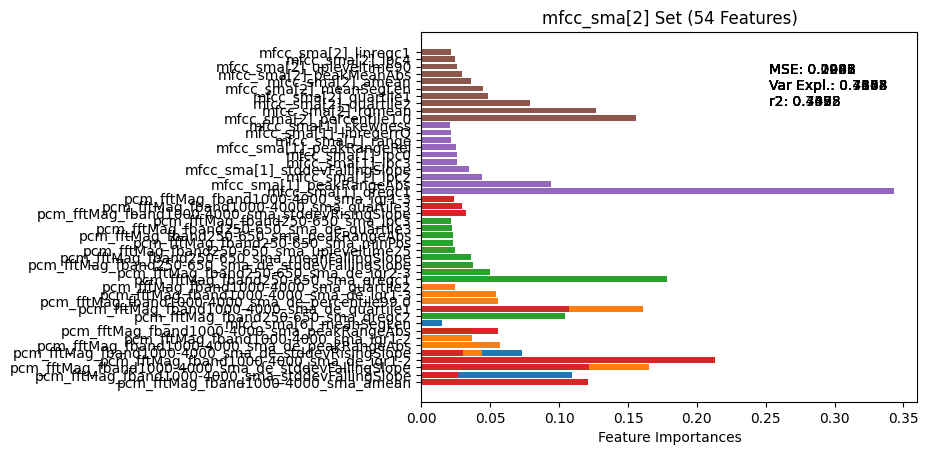

In [234]:
show_plot = False

for i in range(6, ):#range(len(param_set_list)):
    param_set = param_set_list[i]

    X = commalla_compare_2016[commalla_compare_2016.columns.intersection(param_set)]
    y = commalla_compare_2016.mean_arousal

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    rf = RandomForestRegressor(n_estimators=10) # formerly 100
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)
    
    new_row_stats = pd.DataFrame({
        "param_set":[param_set_names[i]]*4, 
        "statistic":["num_features", "mse", "explained_variance", "r2"],
        "value":[len(param_set), 
                 mean_squared_error(y_test, y_pred_test), 
                 explained_variance_score(y_test, y_pred_test), 
                 r2_score(y_test, y_pred_test)]
    })
    param_set_stats = pd.concat([param_set_stats, new_row_stats])

    sort = rf.feature_importances_.argsort()[::-1][:10] # have to reverse order???
    for j in sort:
        new_row_importances = pd.DataFrame({
            "param_set":[param_set_names[i]], 
            "param_name":[X.columns[j]],
            "importance":[rf.feature_importances_[j]],
            })
        param_importances = pd.concat([param_importances, new_row_importances])

    mse = round(mean_squared_error(y_test, y_pred_test), 4) # used functions twice, but need to round vals anyway  
    expl_var =  round(explained_variance_score(y_test, y_pred_test), 4)
    r2score = round(r2_score(y_test, y_pred_test), 4)
    plot_text = " ".join(["MSE:", str(mse), "\nVar Expl.:", str(expl_var), "\nr2:", str(r2score)])

    if show_plot:
        plt.barh(X.columns[sort], rf.feature_importances_[sort])
        plt.title(param_set_names[i]+" Set (" +str(len(param_set))+ " Features)")
        plt.xlabel("Feature Importances")
        plt.annotate(plot_text, xy=(0.7, 0.8), xycoords='axes fraction')
        plt.show()
            

### Notes from different datasets

1. Fband: top 7 features are all fband1000_4000
2. Fband1000_4000 accuracy is much higher than fband250_650; fband1000_4000 accuracy is similar to fband (r2: 0.70 vs 0.73)
3. Suggests fband1000_4000 statistics can predict mean_arousal fairly well 

1. mfcc_sma[1] and mfcc_sma[2] have r2 0.45 and 0.40

lpc = linear predictive coding <br/>
fft = fast fourier transform <br/>
de = delta e (error) <br>
fband = frequency band <br>
pcm = pulse coded magnitude <br>
sma = sample-window moving average <br>


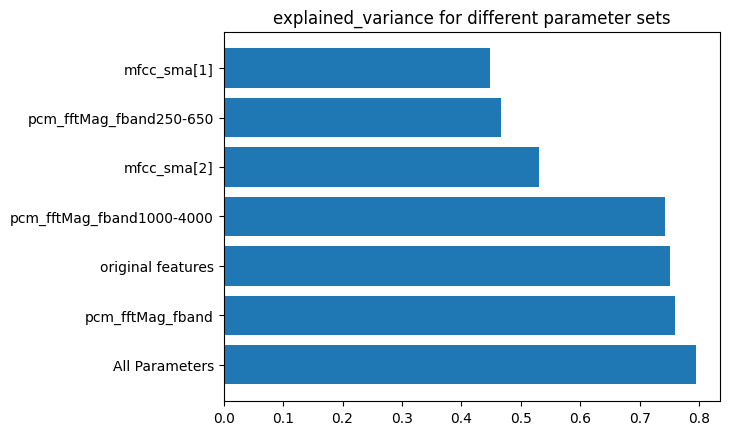

In [249]:
which_stat = "explained_variance"
compare_r2 = param_set_stats[param_set_stats["statistic"]==which_stat]
compare_r2 = compare_r2.sort_values("value", ascending=False)

plt.barh(compare_r2.param_set, compare_r2.value)
plt.title(which_stat + " for different parameter sets")
plt.show()
            

## Original Features Regression

Text(0.7, 0.8, 'MSE: 0.1077 \nVar Expl.: 0.7134 \nr2: 0.7127')

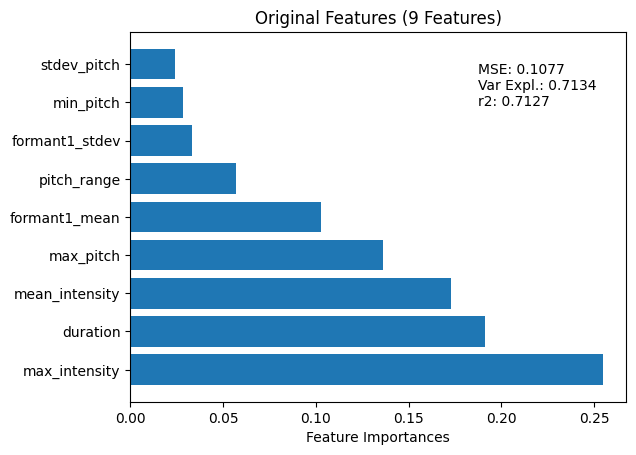

In [5]:
commalla_audio_stats = pd.read_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/files for acoustic_analysis/commalla_audio_stats.csv")

av_stats_melt = pd.read_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/av_stats_melt.csv")
arousal_unmelt = av_stats_melt.groupby(by="filename")["mean_arousal"].mean()

commalla_audio_stats = pd.merge(commalla_audio_stats, arousal_unmelt, how="left", on="filename")
mean_arousal = commalla_audio_stats.pop("mean_arousal")
commalla_audio_stats.insert(5, 'mean_arousal', mean_arousal)

top_features = ["mean_intensity", "max_intensity", "duration", "formant1_mean", "max_pitch", "pitch_range", "stdev_pitch", "min_pitch", "formant1_stdev"]

to_drop = ["Unnamed: 0", "full_pathname", "filename", "recanvo_id", "function"]
commalla_audio_stats = commalla_audio_stats.drop(columns=to_drop).dropna()

X = commalla_audio_stats.drop(columns=["mean_arousal"])
X = X[X.columns.intersection(top_features)]
y = commalla_audio_stats.mean_arousal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf = RandomForestRegressor(n_estimators=10) # formerly 100
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)

sort = rf.feature_importances_.argsort()[::-1][:10] # have to reverse order???

mse = round(mean_squared_error(y_test, y_pred_test), 4) # used functions twice, but need to round vals anyway  
expl_var =  round(explained_variance_score(y_test, y_pred_test), 4)
r2score = round(r2_score(y_test, y_pred_test), 4)
plot_text = " ".join(["MSE:", str(mse), "\nVar Expl.:", str(expl_var), "\nr2:", str(r2score)])

plt.barh(X.columns[sort], rf.feature_importances_[sort])
plt.title("Original Features " + "(" +str(len(X.columns))+ " Features)")
plt.xlabel("Feature Importances")
plt.annotate(plot_text, xy=(0.7, 0.8), xycoords='axes fraction')

In [233]:
new_row_stats = pd.DataFrame({
        "param_set":["original features"]*4, 
        "statistic":["num_features", "mse", "explained_variance", "r2"],
        "value":[28, 
                 mean_squared_error(y_test, y_pred_test), 
                 explained_variance_score(y_test, y_pred_test), 
                 r2_score(y_test, y_pred_test)]
    })
param_set_stats = pd.concat([param_set_stats, new_row_stats]) # only works if you already ran subsets

## Full ComParE_2016 Regression 

Written before Subset Code, used to build other code

In [213]:
X = commalla_compare_2016.iloc[:, 6:] # pathname, misc. columns at beginning 
y = commalla_compare_2016.mean_arousal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# n_estimators = number of trees, distinct from max_depth 
rf = RandomForestRegressor(n_estimators=10) # formerly 100
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred_test))
print("explained variance: ", explained_variance_score(y_test, y_pred_test))
print("r2: ", r2_score(y_test, y_pred_test))


In [167]:
important_features_dict = {}
for idx, val in enumerate(rf.feature_importances_):
    important_features_dict[X.columns[idx]] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'5 most important features: {important_features_list[:5]}')

5 most important features: ['pcm_fftMag_fband1000-4000_sma_stddevFallingSlope', 'pcm_fftMag_fband1000-4000_sma_de_iqr1-2', 'pcm_fftMag_fband1000-4000_sma_quartile3', 'pcm_fftMag_fband1000-4000_sma_de_iqr1-3', 'pcm_fftMag_fband1000-4000_sma_de_quartile1']


6372
pcm_fftMag_fband1000-4000_sma_de_iqr1-2   0.27515371009638834
pcm_fftMag_fband1000-4000_sma_de_stddevFallingSlope   0.21876716674999805
pcm_fftMag_fband1000-4000_sma_stddevFallingSlope   0.05103304253803537
pcm_fftMag_fband250-650_sma_qregc2   0.03905902912187328
audspec_lengthL1norm_sma_rqmean   0.022607261919935014
audSpec_Rfilt_sma_de[8]_peakMeanRel   0.017303667058956442
pcm_fftMag_fband1000-4000_sma_de_stddevRisingSlope   0.01530918409748198
pcm_fftMag_spectralFlux_sma_peakRangeAbs   0.012296129480161877
pcm_fftMag_fband1000-4000_sma_iqr1-2   0.011272969587020246
pcm_fftMag_fband1000-4000_sma_de_iqr2-3   0.010808357584512476


Text(0.5, 0, 'Feature Importance')

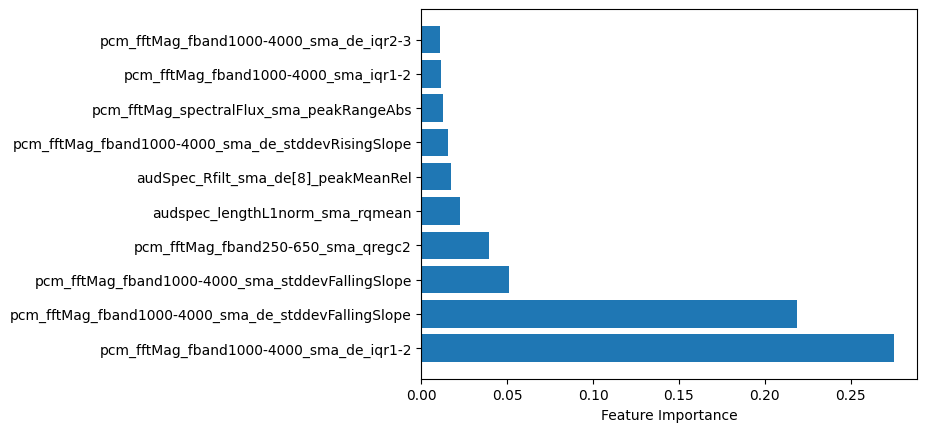

In [215]:
sort = rf.feature_importances_.argsort()[::-1][:10] # have to reverse order???

print(len(X.columns))
for i in sort:
    print(X.columns[i], " ", rf.feature_importances_[i])
    
plt.barh(X.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance") 

# Building Dataframes
https://pypi.org/project/opensmile/ <br>
https://audeering.github.io/opensmile-python/api/opensmile.FeatureSet.html <br>
https://www.arxiv-vanity.com/papers/2005.08848/ <br>

In [3]:
# test run
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    # feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
full_path_row = "/Users/simonrdkn/Dropbox (MIT)/commalla survey audio/p03/p03 dysregulated survey/200411_1548_00-10-52.56--00-10-55.15.wav"
signal, sampling_rate = audiofile.read(full_path_row)
row_data = smile.process_signal(signal, sampling_rate)

row_data

,,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
start,end,,,,,,,,,,,,,,,,,,,,,
0 days,0 days 00:00:02.585986,2.566683,0.135458,0.039841,2.033635,2.187373,2.428145,0.153738,0.240772,0.394511,0.341373,...,4.320541,0.503799,1.965287,2.041407,-15.512658,0.482777,77.6689,27.301645,86.110924,49.087955


In [ ]:
path_tree = []
for node in os.walk("/Users/simonrdkn/Dropbox (MIT)/commalla survey audio"):
    path_tree.append(node)

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    # feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

commalla_compare_2016 = pd.DataFrame({
    "full_pathname":[],
    "filename":[],
    "recanvo_id":[],
    "function":[]
    })

for feature in smile.feature_names: # takes 20s to run 
    commalla_compare_2016[feature] = [] 

In [3]:
for folder_tup in path_tree:
    # structure = (pathname of folder, empty [], .wav filenames)
    foldername = folder_tup[0]
    if len(foldername)>67 and len(folder_tup[1])==0:
        for possible_fx in ['delighted', 'frustrated', "request", "self talk", "dysregulated"]:
            if possible_fx in foldername:
                fx_row = possible_fx # other words are formatted identically
                
        for filename in folder_tup[2]:
            if fx_row == "self talk": # making it match the qualtrics_key format
                fx_row = "selftalk"

            full_path_row = "/".join([foldername,filename])
            signal, sampling_rate = audiofile.read(full_path_row)
            row_data = smile.process_signal(signal, sampling_rate)

            new_row = {
                "full_pathname":[full_path_row],
                "filename":[filename],
                "recanvo_id":[foldername[53:56]],
                "function":[fx_row],
            }
            
            for col in row_data.columns:
                new_row[col] = row_data[col]

            commalla_compare_2016 = pd.concat([commalla_compare_2016, pd.DataFrame(new_row)])


In [13]:
av_stats_melt = pd.read_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/av_stats_melt.csv")
valence_unmelt = av_stats_melt.groupby(by="filename")["mean_valence"].mean()

commalla_compare_2016 = pd.merge(commalla_compare_2016, valence_unmelt, how="left", on="filename")
mean_valence = commalla_compare_2016.pop("mean_valence")
commalla_compare_2016.insert(4, 'mean_valence', mean_valence)

# check to make sure mean_arousal isn't added multiple times
for name in commalla_compare_2016.columns:
    if "arousal" in name:
        print(name)
        
# commalla_compare_2016.to_csv('/Users/simonrdkn/Documents/commalla_acoustic_analysis/commalla_compare_2016.csv')


mean_valence


## GeMAPS DF

In [12]:
path_tree = []
for node in os.walk("/Users/simonrdkn/Dropbox (MIT)/commalla survey audio"):
    path_tree.append(node)

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01a,
    # feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

commalla_gemaps = pd.DataFrame({
    "full_pathname":[],
    "filename":[],
    "recanvo_id":[],
    "function":[]
    })

for feature in smile.feature_names: # takes 20s to run 
    commalla_gemaps[feature] = [] 

/Users/simonrdkn/Library/Python/3.9/lib/python/site-packages/opensmile/core/smile.py:256: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(


In [13]:
for folder_tup in path_tree:
    # structure = (pathname of folder, empty [], .wav filenames)
    foldername = folder_tup[0]
    if len(foldername)>67 and len(folder_tup[1])==0:
        for possible_fx in ['delighted', 'frustrated', "request", "self talk", "dysregulated"]:
            if possible_fx in foldername:
                fx_row = possible_fx # other words are formatted identically
                
        for filename in folder_tup[2]:
            if fx_row == "self talk": # making it match the qualtrics_key format
                fx_row = "selftalk"

            full_path_row = "/".join([foldername,filename])
            signal, sampling_rate = audiofile.read(full_path_row)
            row_data = smile.process_signal(signal, sampling_rate)

            new_row = {
                "full_pathname":[full_path_row],
                "filename":[filename],
                "recanvo_id":[foldername[53:56]],
                "function":[fx_row],
            }
            
            for col in row_data.columns:
                new_row[col] = row_data[col]

            commalla_gemaps = pd.concat([commalla_gemaps, pd.DataFrame(new_row)])

In [14]:
av_stats_melt = pd.read_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/av_stats_melt.csv")
arousal_unmelt = av_stats_melt.groupby(by="filename")["mean_arousal"].mean()
valence_unmelt = av_stats_melt.groupby(by="filename")["mean_valence"].mean()

commalla_gemaps = pd.merge(commalla_gemaps, arousal_unmelt, how="left", on="filename")
commalla_gemaps = pd.merge(commalla_gemaps, valence_unmelt, how="left", on="filename")

mean_arousal = commalla_gemaps.pop("mean_arousal")
mean_valence = commalla_gemaps.pop("mean_valence")

commalla_gemaps.insert(4, 'mean_arousal', mean_arousal)
commalla_gemaps.insert(4, 'mean_valence', mean_valence)

In [15]:
# Check if arousal and valence are added multiple times
for colname in commalla_gemaps.columns: 
    if "arousal" in colname:
        print(colname)
    if "valence" in colname:
        print(colname)

# commalla_gemaps.to_csv("/Users/simonrdkn/Documents/commalla_acoustic_analysis/feature sets/gemaps_extended.csv")

mean_valence
mean_arousal
